# Question A1 (15 marks)

#### Design a feedforward deep neural network (DNN) which consists of **three** hidden layers of 128 neurons each with ReLU activation function, and an output layer with sigmoid activation function. Apply dropout of probability **0.2** to each of the hidden layers.

In [1]:
import tqdm
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

!pip install torch
import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from scipy.io import wavfile as wav

from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

from common_utils import set_seed

# setting seed
set_seed()

1.Define the model class.

In [ ]:
# class MLP(nn.Module):

#     def __init__(self, no_features, no_hidden, no_labels):
#         super().__init__()
#         self.mlp_stack = nn.Sequential(
#             # YOUR CODE HERE
#         )

#     # YOUR CODE HERE

In [2]:
class MLP(nn.Module):
    def __init__(self, no_features, no_hidden, no_labels):
        super().__init__()
        self.mlp_stack = nn.Sequential(
            nn.Linear(no_features, no_hidden),  # First hidden layer
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(no_hidden, no_hidden),    # Second hidden layer
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(no_hidden, no_hidden),    # Third hidden layer
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(no_hidden, no_labels),    # Output layer
            nn.Sigmoid()
        )
        
    # YOUR CODE HERE
    def forward(self, x):
        return self.mlp_stack(x)

#### Divide the dataset into a 80:20 ratio for training and testing. Use **appropriate** scaling of input features. We solely assume that there are only two datasets here: training & test.

2.Split the dataset and do preprocessing.

In [ ]:
# from common_utils import split_dataset, preprocess_dataset


# def preprocess(df):
#     # YOUR CODE HERE
#     return X_train_scaled, y_train, X_test_scaled, y_test

# df = pd.read_csv('simplified.csv')
# df['label'] = df['filename'].str.split('_').str[-2]

# df['label'].value_counts()

# X_train_scaled, y_train, X_test_scaled, y_test = preprocess(df)

In [7]:
from common_utils import split_dataset, preprocess_dataset

def preprocess(df):
    # Dropping the 'filename' column since it is not a feature for training
    df['label'] = df['filename'].apply(lambda x: 1 if '_pos_' in x else 0)  # 1 for positive, 0 for negative
    df = df.drop(columns=['filename'])

    # Separating features and labels
    X = df.drop(columns=['label'])
    y = df['label']

    # Scaling features
    scaler = preprocessing.StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Splitting the dataset into 80:20 for train/test
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

    # Reset index to avoid KeyError during DataLoader iteration
    y_train = y_train.reset_index(drop=True)
    y_test = y_test.reset_index(drop=True)
    
    return X_train, y_train, X_test, y_test

# Load the dataset
df = pd.read_csv('simplified.csv')

# Preprocess the dataset
X_train_scaled, y_train, X_test_scaled, y_test = preprocess(df)

#### Use the training dataset to train the model for 100 epochs. Use a mini-batch gradient descent with **‘Adam’** optimizer with learning rate of **0.001**, and **batch size = 128**. Implement early stopping with patience of **3**.

3.Define a Pytorch Dataset and Dataloaders.  

In [ ]:
# class CustomDataset(Dataset):
#     # YOUR CODE HERE


# def intialise_loaders(X_train_scaled, y_train, X_test_scaled, y_test):
#     # YOUR CODE HERE
#     return train_dataloader, test_dataloader

# train_dataloader, test_dataloader = intialise_loaders(X_train_scaled, y_train, X_test_scaled, y_test)

In [8]:
class CustomDataset(Dataset):
    # YOUR CODE HERE
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return torch.tensor(self.X[idx], dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)

def initialise_loaders(X_train_scaled, y_train, X_test_scaled, y_test, batch_size=128):
    train_dataset = CustomDataset(X_train_scaled, y_train)
    test_dataset = CustomDataset(X_test_scaled, y_test)

    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_dataloader, test_dataloader

train_dataloader, test_dataloader = initialise_loaders(X_train_scaled, y_train, X_test_scaled, y_test)

4.Next, define the model, optimizer and loss function.

In [ ]:
# # YOUR CODE HERE
# model =
# optimizer =
# loss_fn =

In [9]:
# YOUR CODE HERE
no_features = X_train_scaled.shape[1]  # Number of features in the dataset
no_hidden = 128                        # Hidden layer size
no_labels = 1                          # Output size (binary classification)

model = MLP(no_features, no_hidden, no_labels)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.BCELoss()  # Binary Cross Entropy Loss for binary classification


5.Train model for 100 epochs. Record down train and test accuracies. Implement early stopping.

In [10]:
# YOUR CODE HERE
def train_model(model, train_dataloader, test_dataloader, optimizer, loss_fn, epochs=100, patience=3):
    train_losses, test_losses = [], []
    train_accs, test_accs = [], []  # Initialize these as empty lists, not unpack them.

    best_loss = float('inf')
    patience_counter = 0

    for epoch in range(epochs):
        model.train()
        train_loss, correct = 0, 0
        for X_batch, y_batch in train_dataloader:
            optimizer.zero_grad()
            outputs = model(X_batch).squeeze()
            loss = loss_fn(outputs, y_batch)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            preds = (outputs > 0.5).float()
            correct += (preds == y_batch).sum().item()

        train_losses.append(train_loss / len(train_dataloader))
        train_accs.append(correct / len(train_dataloader.dataset))

        # Validation
        model.eval()
        test_loss, correct = 0, 0
        with torch.no_grad():
            for X_batch, y_batch in test_dataloader:
                outputs = model(X_batch).squeeze()
                loss = loss_fn(outputs, y_batch)
                test_loss += loss.item()
                preds = (outputs > 0.5).float()
                correct += (preds == y_batch).sum().item()

        test_losses.append(test_loss / len(test_dataloader))
        test_accs.append(correct / len(test_dataloader.dataset))

        # Early stopping
        if test_losses[-1] < best_loss:
            best_loss = test_losses[-1]
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch + 1}")
            break

        print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}, Train Acc: {train_accs[-1]:.4f}, Test Acc: {test_accs[-1]:.4f}")

    return train_losses, test_losses, train_accs, test_accs


train_losses, test_losses, train_accs, test_accs = train_model(model, train_dataloader, test_dataloader, optimizer, loss_fn)

Epoch 1/100, Train Loss: 0.6827, Test Loss: 0.6707, Train Acc: 0.5559, Test Acc: 0.5796
Epoch 2/100, Train Loss: 0.6656, Test Loss: 0.6511, Train Acc: 0.5961, Test Acc: 0.6235
Epoch 3/100, Train Loss: 0.6496, Test Loss: 0.6425, Train Acc: 0.6153, Test Acc: 0.6219
Epoch 4/100, Train Loss: 0.6343, Test Loss: 0.6258, Train Acc: 0.6372, Test Acc: 0.6476
Epoch 5/100, Train Loss: 0.6163, Test Loss: 0.6171, Train Acc: 0.6609, Test Acc: 0.6563
Epoch 6/100, Train Loss: 0.5946, Test Loss: 0.6006, Train Acc: 0.6744, Test Acc: 0.6704
Epoch 7/100, Train Loss: 0.5768, Test Loss: 0.6020, Train Acc: 0.6909, Test Acc: 0.6766
Epoch 8/100, Train Loss: 0.5643, Test Loss: 0.5862, Train Acc: 0.7034, Test Acc: 0.6857
Epoch 9/100, Train Loss: 0.5458, Test Loss: 0.5857, Train Acc: 0.7193, Test Acc: 0.6886
Epoch 10/100, Train Loss: 0.5237, Test Loss: 0.5588, Train Acc: 0.7370, Test Acc: 0.7181
Epoch 11/100, Train Loss: 0.5058, Test Loss: 0.5551, Train Acc: 0.7477, Test Acc: 0.7094
Epoch 12/100, Train Loss: 0.49

In [16]:
torch.save(model.state_dict(), 'mlp_pretrained_weights.pth')

#### Plot train and test accuracies and losses on training and test data against training epochs and comment on the line plots.


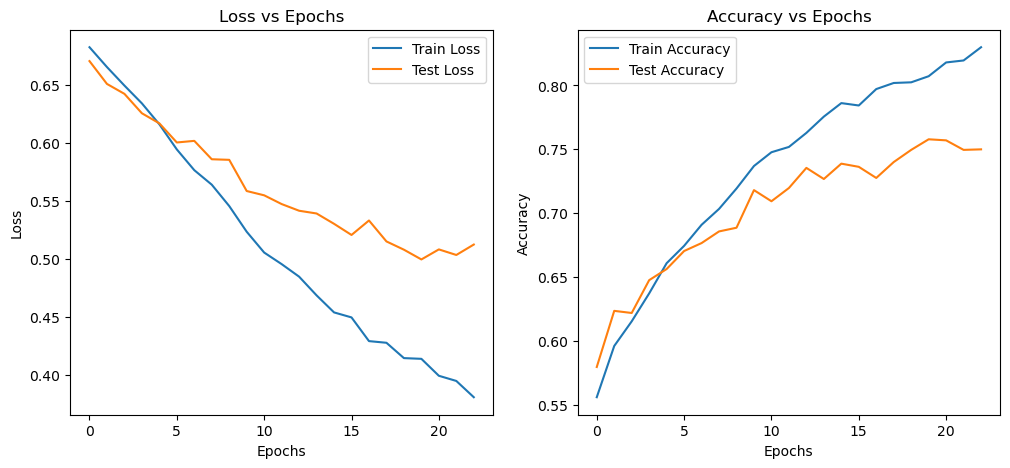

In [11]:
# YOUR CODE HERE

# Plotting the results
epochs = len(train_losses)

plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(range(epochs), train_losses, label='Train Loss')
plt.plot(range(epochs), test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss vs Epochs')

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(range(epochs), train_accs, label='Train Accuracy')
plt.plot(range(epochs), test_accs, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy vs Epochs')

plt.show()

6.Comment on line plots.

In [15]:
# YOUR CODE HERE
answer = """
The line plots give valuable insights into the model's training process and its ability to generalize.

For the **Loss vs Epochs** plot:
- **Training Loss**: The consistent decline in training loss indicates that the model is learning effectively, reducing its errors on the training data.
- **Test Loss**: While the test loss decreases initially, it starts to fluctuate and even increases slightly after a certain point. This suggests **overfitting**, where the model is becoming too tailored to the training data and struggles to generalize to new, unseen data.

For the **Accuracy vs Epochs** plot:
- **Training Accuracy**: The steady improvement in training accuracy shows that the model is increasingly able to classify the training data correctly. However, the widening gap between training and test accuracy after about 10 epochs suggests that the model might be overfitting.
- **Test Accuracy**: The test accuracy rises at first but then levels off, peaking around 75%. This indicates that the model's performance on unseen data stops improving, despite continued gains in training accuracy.

In conclusion, the model shows clear signs of overfitting as training progresses. Techniques such as increasing dropout, using L2 regularization, or implementing early stopping could help improve the model's generalization and prevent overfitting.
"""